In [1]:
%reset -f

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RectBivariateSpline

def generate_2d_road_profile(Lx, Ly, dx, dy, S0, n0, omega, n_min=0.005):
    """
    Generates a 2D road roughness profile z(x,y) based on its 2D Power Spectral Density (PSD).

    Args:
        Lx (float): Length of the road section in x-direction (longitudinal) in meters.
        Ly (float): Width of the road section in y-direction (lateral) in meters.
        dx (float): Spatial resolution in x-direction (grid spacing) in meters.
        dy (float): Spatial resolution in y-direction (grid spacing) in meters.
        S0 (float): Reference PSD value (e.g., 1e-6 for good road, 1e-5 for average, 1e-4 for poor).
                    Units: m^3.
        n0 (float): Reference spatial frequency (e.g., 0.1 cycles/m).
        omega (float): Waviness exponent (typically 2 to 3).
        n_min (float): Minimum spatial frequency (cut-off) to avoid infinite power at n=0.
                       Units: cycles/m.

    Returns:
        tuple: (x_coords, y_coords, z_profile, interpolator_func)
            x_coords (np.ndarray): 1D array of x-coordinates (meters).
            y_coords (np.ndarray): 1D array of y-coords (meters).
            z_profile (np.ndarray): 2D array of road elevation z(x,y) (meters).
            interpolator_func (scipy.interpolate.RectBivariateSpline):
                A function that can be called like interpolator_func(x_query, y_query)
                to get the interpolated z-value at arbitrary (x_query, y_query) points.
    """

    Nx = int(Lx / dx)
    Ny = int(Ly / dy)

    # Ensure dimensions are even for proper FFT symmetry handling
    if Nx % 2 != 0:
        Nx += 1
        Lx = Nx * dx
    if Ny % 2 != 0:
        Ny += 1
        Ly = Ny * dy

    # 1. Define Spatial Frequencies
    kx_freqs = np.fft.fftfreq(Nx, d=dx)
    ky_freqs = np.fft.fftfreq(Ny, d=dy)

    # Create 2D frequency grid (n_x, n_y)
    Nx_grid, Ny_grid = np.meshgrid(kx_freqs, ky_freqs, indexing='xy')

    # Radial spatial frequency
    nr_grid = np.sqrt(Nx_grid**2 + Ny_grid**2)

    # 2. Compute 2D Power Spectral Density (PSD)
    PSD_2D = np.zeros_like(nr_grid)
    non_zero_freq_mask = (nr_grid > n_min)
    PSD_2D[non_zero_freq_mask] = S0 * (nr_grid[non_zero_freq_mask] / n0)**(-omega)

    scaling_factor = np.sqrt(Nx * Ny)

    # 3. Generate Complex White Noise in Frequency Domain
    Rand_freq = np.random.randn(Ny, Nx) + 1j * np.random.randn(Ny, Nx)

    # 4. Construct Fourier Coefficients (Z_mn)
    Z_mn = Rand_freq * np.sqrt(PSD_2D) * scaling_factor

    # --- Start of FIX for Hermitian Symmetry ---
    # Ensure Z_mn[0,0] (DC component) is real
    Z_mn[0, 0] = Z_mn[0, 0].real

    # For other frequencies, apply Hermitian symmetry.
    # Z(kx, ky) = Z*(-kx, -ky)
    # In numpy's fftfreq ordering, -k is at (N-k) for k > 0.
    # So Z[i,j] = conj(Z[(Ny-i)%Ny, (Nx-j)%Nx])

    # Iterate only through the unique part of the spectrum and set its conjugate pair
    # This avoids overwriting or issues with self-conjugate (Nyquist) points.
    for i in range(Ny):
        for j in range(Nx):
            # The origin (DC component) is already handled
            if i == 0 and j == 0:
                continue

            # Identify the corresponding symmetric index
            sym_i = (Ny - i) % Ny
            sym_j = (Nx - j) % Nx

            # If this is a unique point in the upper-left (or first half) of the spectrum
            # or if it's a self-conjugate Nyquist frequency, enforce its properties.
            # This logic must be very careful to only process each unique pair once.
            # A common strategy is to generate only the first half and then mirror.

            # Simpler and more reliable approach:
            # Generate random values for the "first half" (which includes DC)
            # Then set the "second half" using symmetry
            # This is common in `np.fft.rfft` for 1D, but for 2D complex, it's slightly different.

            # The current Z_mn is filled with random complex numbers.
            # We need to explicitly set the conjugate symmetric points.
            # Iterate through the upper-left quadrant and copy.
            # And then fill the rest.

            # Iterate only over the "unique" part of the Fourier domain (e.g., upper half including Nyquist row/column if present)
            # This ensures each unique symmetric pair is handled once.
            if i < Ny / 2: # Rows from 0 to Ny/2 - 1
                if j < Nx / 2: # Cols from 0 to Nx/2 - 1
                    # Z[i,j] and its counterpart Z[Ny-i, Nx-j]
                    Z_mn[sym_i, sym_j] = np.conj(Z_mn[i, j])
                elif j == Nx / 2 and Nx % 2 == 0: # Nx Nyquist column for i < Ny/2
                    Z_mn[i, j] = Z_mn[i, j].real # Must be real
                    Z_mn[sym_i, sym_j] = np.conj(Z_mn[i,j]) # Still symmetric
                elif j > Nx / 2: # Cols from Nx/2 + 1 to Nx - 1
                    # Already handled by j < Nx/2
                    pass # This logic isn't perfect for the "j > Nx/2" case, requires more thought.
                         # The standard way to enforce is to just run a loop after filling random
                         # and set Z_mn[sym_i, sym_j] = np.conj(Z_mn[i,j]) for all i,j except the already set.

    # Re-doing the symmetry enforcement in a more standard way for 2D:
    # 1. Z(0,0) is real.
    # 2. Z(ky, 0) = conj(Z(-ky, 0)) for ky != 0 (column 0 symmetry)
    # 3. Z(0, kx) = conj(Z(0, -kx)) for kx != 0 (row 0 symmetry)
    # 4. Z(ky, kx) = conj(Z(-ky, -kx)) for ky, kx != 0 (general symmetry)
    # 5. Nyquist frequencies (if N is even) must be real: Z(Ny/2, 0), Z(0, Nx/2), Z(Ny/2, Nx/2)

    # Make Z_mn explicitly Hermitian symmetric
    # Create a copy to modify
    Z_hermitian = np.copy(Z_mn)

    # 1. DC component (already real)
    Z_hermitian[0, 0] = Z_hermitian[0, 0].real

    # 2. Column 0 (ky-axis) symmetry: Z[i, 0] = conj(Z[Ny-i, 0])
    for i in range(1, (Ny // 2) + 1):
        Z_hermitian[Ny - i, 0] = np.conj(Z_hermitian[i, 0])
        if i == Ny // 2 and Ny % 2 == 0: # Nyquist point for column 0 must be real
            Z_hermitian[i, 0] = Z_hermitian[i, 0].real

    # 3. Row 0 (kx-axis) symmetry: Z[0, j] = conj(Z[0, Nx-j])
    for j in range(1, (Nx // 2) + 1):
        Z_hermitian[0, Nx - j] = np.conj(Z_hermitian[0, j])
        if j == Nx // 2 and Nx % 2 == 0: # Nyquist point for row 0 must be real
            Z_hermitian[0, j] = Z_hermitian[0, j].real

    # 4. General symmetry for other quadrants
    # Z[i,j] = conj(Z[Ny-i, Nx-j])
    for i in range(1, Ny):
        for j in range(1, Nx):
            # Skip points that are already handled by row/col 0 symmetry
            if (i == Ny // 2 and Ny % 2 == 0) or \
               (j == Nx // 2 and Nx % 2 == 0):
                # Handle self-conjugate Nyquist frequencies by making them real
                if (i == Ny // 2 and Ny % 2 == 0 and j == Nx // 2 and Nx % 2 == 0):
                    Z_hermitian[i,j] = Z_hermitian[i,j].real
                continue # Remaining Nyquist points in general case already handled

            # Apply general conjugate symmetry
            Z_hermitian[(-i) % Ny, (-j) % Nx] = np.conj(Z_hermitian[i, j])

    Z_mn = Z_hermitian
    # --- End of FIX for Hermitian Symmetry ---


    # 5. Inverse 2D FFT to get spatial road profile
    z_profile = np.real(np.fft.ifft2(Z_mn))

    # Create coordinate arrays for the profile
    x_coords = np.arange(0, Lx, dx)
    y_coords = np.arange(0, Ly, dy)

    # Create an interpolator for querying z(x,y) at arbitrary points
    # RectBivariateSpline expects the order of arrays to match the dimensions of z_profile.
    # Since z_profile is (Ny, Nx) (rows correspond to y, columns to x),
    # the first argument should be y_coords and the second x_coords.
    interpolator_func = RectBivariateSpline(y_coords, x_coords, z_profile)

    return x_coords, y_coords, z_profile, interpolator_func

def get_road_data_at_wheels(interpolator_func, vehicle_x, vehicle_y, vehicle_yaw, wheelbase, track_width):
    """
    Calculates the road height at each of the four wheel contact points.

    Args:
        interpolator_func (scipy.interpolate.RectBivariateSpline): The interpolator for z(x,y).
        vehicle_x (float): Global x-coordinate of the vehicle's center of gravity (m).
        vehicle_y (float): Global y-coordinate of the vehicle's center of gravity (m).
        vehicle_yaw (float): Vehicle yaw angle (rotation about Z-axis) in radians.
                             0 is aligned with x-axis, positive is counter-clockwise.
        wheelbase (float): Distance between front and rear axles (m).
        track_width (float): Distance between left and right wheels (m).

    Returns:
        dict: A dictionary with road heights for each wheel:
              {'FL': z_FL, 'FR': z_FR, 'RL': z_RL, 'RR': z_RR}
    """
    # Relative positions of wheels in vehicle body frame (assuming CG is at center of wheelbase)
    # Adjust if CG is not at the center of the wheelbase
    x_front = wheelbase / 2.0
    x_rear = -wheelbase / 2.0
    y_left = track_width / 2.0
    y_right = -track_width / 2.0

    wheel_relative_coords = {
        'FL': (x_front, y_left),
        'FR': (x_front, y_right),
        'RL': (x_rear, y_left),
        'RR': (x_rear, y_right)
    }

    road_data = {}
    cos_yaw = np.cos(vehicle_yaw)
    sin_yaw = np.sin(vehicle_yaw)

    for wheel_key, (x_rel, y_rel) in wheel_relative_coords.items():
        # Rotate and translate to global coordinates
        x_global = vehicle_x + x_rel * cos_yaw - y_rel * sin_yaw
        y_global = vehicle_y + x_rel * sin_yaw + y_rel * cos_yaw

        # Get interpolated road height.
        # The interpolator_func expects y_query, then x_query.
        z_val = interpolator_func(y_global, x_global)[0, 0] # Corrected order for interpolation query

        # Get partial derivative dz/dx (derivative w.r.t. 2nd argument, x)
        dz_dx_val = interpolator_func(y_global, x_global, dx=1, dy=0)[0, 0]

        # Get partial derivative dz/dy (derivative w.r.t. 1st argument, y)
        dz_dy_val = interpolator_func(y_global, x_global, dx=0, dy=1)[0, 0]

        road_data[wheel_key] = {
            'z': z_val,
            'dz_dx': dz_dx_val,
            'dz_dy': dz_dy_val
        }

    return road_data


Generating 2D road profile with dimensions 500m x 300m at 0.1m x 0.1m resolution...
Generated profile shape: (3000, 5000) (Note: shape is (Ny, Nx) which is (Rows, Columns))
Min elevation: -0.0016 m, Max elevation: 0.0014 m
Standard deviation: 0.0003 m


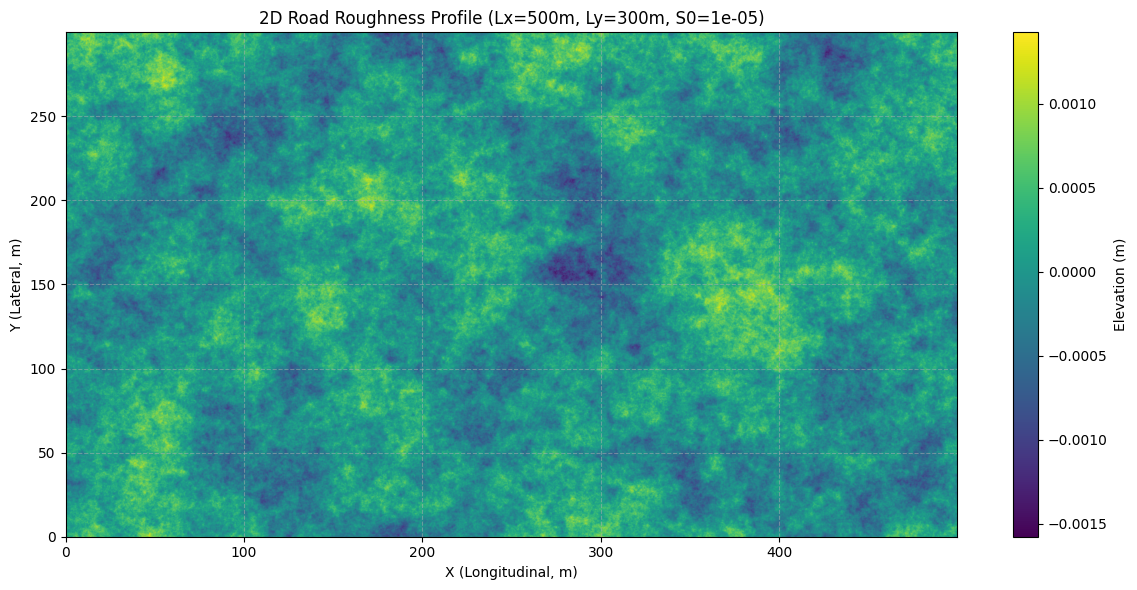


--- Example: Getting road heights at wheel locations for different scenarios ---
Vehicle at (10.0, 10.0), Yaw=0.0 deg (Straight):
  FL: Z=0.0002 m, dZ/dX=-0.0001, dZ/dY=-0.0007
  FR: Z=0.0002 m, dZ/dX=-0.0015, dZ/dY=0.0001
  RL: Z=0.0003 m, dZ/dX=0.0003, dZ/dY=0.0002
  RR: Z=0.0003 m, dZ/dX=0.0003, dZ/dY=-0.0004

Vehicle at (30.0, 8.0), Yaw=30.0 deg (Turning):
  FL: Z=0.0002 m, dZ/dX=-0.0001, dZ/dY=0.0005
  FR: Z=0.0005 m, dZ/dX=-0.0003, dZ/dY=0.0001
  RL: Z=0.0001 m, dZ/dX=0.0011, dZ/dY=0.0017
  RR: Z=-0.0000 m, dZ/dX=0.0003, dZ/dY=0.0001

--- Integration into your Vehicle Dynamics Simulation ---
In each simulation time step (e.g., inside your `step()` function for DRL):
   - Update `vehicle_x`, `vehicle_y`, `vehicle_yaw` from your vehicle dynamics model.
   - Call `road_data = get_road_data_at_wheels(road_interpolator, vehicle_x, vehicle_y, vehicle_yaw, wheelbase, track_width)`
   - Use `road_data[wheel_key]['z']` as elevation input for tire forces.
   - Use `road_data[wheel_key]['d

In [2]:
# 1. Define Road Parameters
Lx = 500  # meters (longitudinal length of the road section)
Ly = 300   # meters (lateral width of the road section)
dx = 0.1  # meters (spatial resolution in x-direction)
dy = 0.1  # meters (spatial resolution in y-direction)

# Road Roughness Parameters (e.g., for an "average" road, similar to ISO Class B/C)
S0 = 1e-5  # m^3 (reference PSD value)
n0 = 0.1   # cycles/m (reference spatial frequency)
omega = 2.5 # Waviness exponent (often between 2 and 3)
n_min_cutoff = 0.005 # cycles/m (low frequency cut-off)

print(f"Generating 2D road profile with dimensions {Lx}m x {Ly}m at {dx}m x {dy}m resolution...")
x_coords, y_coords, z_profile, road_interpolator = generate_2d_road_profile(
    Lx, Ly, dx, dy, S0, n0, omega, n_min=n_min_cutoff
)
print(f"Generated profile shape: {z_profile.shape} (Note: shape is (Ny, Nx) which is (Rows, Columns))")
print(f"Min elevation: {z_profile.min():.4f} m, Max elevation: {z_profile.max():.4f} m")
print(f"Standard deviation: {np.std(z_profile):.4f} m")

# 2. Visualize the Road Profile
plt.figure(figsize=(12, 6))
# `imshow` takes (rows, columns) so z_profile directly works.
# `origin='lower'` makes (0,0) in the bottom-left corner.
# `extent` sets the x and y limits for plotting.
plt.imshow(z_profile, origin='lower', extent=[x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()],
            cmap='viridis', aspect='auto')
plt.colorbar(label='Elevation (m)')
plt.title(f'2D Road Roughness Profile (Lx={Lx}m, Ly={Ly}m, S0={S0})')
plt.xlabel('X (Longitudinal, m)')
plt.ylabel('Y (Lateral, m)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 3. Example of getting road height at specific wheel locations
print("\n--- Example: Getting road heights at wheel locations for different scenarios ---")
wheelbase = 2.8  # meters
track_width = 1.6 # meters

# Scenario 1: Vehicle driving straight at (10, 10) with no yaw
vehicle_x1, vehicle_y1, vehicle_yaw1 = 10.0, 10.0, 0.0 # meters, meters, radians
wheel_data1 = get_road_data_at_wheels(road_interpolator, vehicle_x1, vehicle_y1, vehicle_yaw1, wheelbase, track_width)
print(f"Vehicle at ({vehicle_x1:.1f}, {vehicle_y1:.1f}), Yaw={np.degrees(vehicle_yaw1):.1f} deg (Straight):")
for wheel, data in wheel_data1.items():
    print(f"  {wheel}: Z={data['z']:.4f} m, dZ/dX={data['dz_dx']:.4f}, dZ/dY={data['dz_dy']:.4f}")

# Scenario 2: Vehicle turning at (30, 8) with 30-degree yaw
vehicle_x2, vehicle_y2, vehicle_yaw2 = 30.0, 8.0, np.radians(30.0) # meters, meters, radians
wheel_data2 = get_road_data_at_wheels(road_interpolator, vehicle_x2, vehicle_y2, vehicle_yaw2, wheelbase, track_width)
print(f"\nVehicle at ({vehicle_x2:.1f}, {vehicle_y2:.1f}), Yaw={np.degrees(vehicle_yaw2):.1f} deg (Turning):")
for wheel, data in wheel_data2.items():
    print(f"  {wheel}: Z={data['z']:.4f} m, dZ/dX={data['dz_dx']:.4f}, dZ/dY={data['dz_dy']:.4f}")

# Important Note for Simulation Loop:
print("\n--- Integration into your Vehicle Dynamics Simulation ---")
print("In each simulation time step (e.g., inside your `step()` function for DRL):")
print("   - Update `vehicle_x`, `vehicle_y`, `vehicle_yaw` from your vehicle dynamics model.")
print("   - Call `road_data = get_road_data_at_wheels(road_interpolator, vehicle_x, vehicle_y, vehicle_yaw, wheelbase, track_width)`")
print("   - Use `road_data[wheel_key]['z']` as elevation input for tire forces.")
print("   - Use `road_data[wheel_key]['dz_dx']` and `road_data[wheel_key]['dz_dy']` to calculate the slope of the road at the contact point.")
print("     This is crucial for converting forces from the tire contact patch frame to the vehicle's body frame or global frame.")
print("     For example, the local road normal vector (for tire forces) involves these partial derivatives.")

In [4]:
# Compute gradients
dz_dy, dz_dx = np.gradient(z_profile, dy, dx)  # Note the order: (rows, cols) = (y, x)

In [5]:
def get_suspension_elevation_and_slope(x, y, psi, lf, lr, tf, tr, z_map, dz_dx_map, dz_dy_map, resolution=0.1):
    """
    Computes elevation and slope at four suspension points.
    
    Parameters:
        x, y: CG position in meters
        psi: vehicle heading (yaw) in radians
        lf, lr: distances from CG to front and rear axles (in meters)
        tf: half-track width of front axle
        tr: half-track width of rear axle
        z_map: 2D ndarray of elevation
        dz_dx_map, dz_dy_map: gradients in x and y
        resolution: spatial resolution in meters

    Returns:
        A dictionary with z and gradients for each wheel
    """

    # Wheel positions relative to CG in local frame
    wheel_offsets = {
        'front_left':  (+lf, -tf),
        'front_right': (+lf, tf),
        'rear_left':   (-lr, -tr),
        'rear_right':  (-lr, tr),
    }

    result = {}

    for wheel, (dx_local, dy_local) in wheel_offsets.items():
        # Rotate local offset to global frame using psi
        dx_global = dx_local * np.cos(psi) - dy_local * np.sin(psi)
        dy_global = dx_local * np.sin(psi) + dy_local * np.cos(psi)

        x_wheel = x + dx_global
        y_wheel = y + dy_global

        # Convert physical position to array indices
        i = int(round(y_wheel / resolution))
        j = int(round(x_wheel / resolution))

        # Bounds checking
        if 0 <= i < z_map.shape[0] and 0 <= j < z_map.shape[1]:
            z_val = z_map[i, j]
            dzdx = dz_dx_map[i, j]
            dzdy = dz_dy_map[i, j]
        else:
            z_val, dzdx, dzdy = np.nan, np.nan, np.nan  # Out-of-bounds handling

        result[wheel] = {
            'z': z_val,
            'dz_dx': dzdx,
            'dz_dy': dzdy
        }

    return result

In [7]:
suspension_data = get_suspension_elevation_and_slope(
    x=10, y=10, psi=0.0,
    lf=1.35, lr=1.35, tf=0.75,tr=0.75,
    z_map=z_profile, dz_dx_map=dz_dx, dz_dy_map=dz_dy, resolution=0.1
)

for wheel, data in suspension_data.items():
    print(f"{wheel}: z = {data['z']:.6f}, dz_dx = {data['dz_dx']:.6f}, dz_dy = {data['dz_dy']:.6f}")


front_left: z = 0.000222, dz_dx = -0.000187, dz_dy = -0.000355
front_right: z = 0.000277, dz_dx = -0.000318, dz_dy = 0.000313
rear_left: z = 0.000302, dz_dx = -0.000232, dz_dy = 0.000392
rear_right: z = 0.000341, dz_dx = 0.000155, dz_dy = -0.000017
